# Welcome to the Future :)
Notebook by Rayce Stipanovich

[Check out Point-E in this great blog post](https://dagshub.com/blog/overview-of-point-e/)

This is a Python Jupyter Notebook designed to output low-poly .gltf files for use in 3D content or web stuff.

### Relies on:
- Python v3, Jupyter Notebooks
- NVIDIA CUDA v11.7 (or your CPU if you're a noob)
- OpenAI's Point-E Beta
- Blender w/ .gltf Exporter extension

### Installation and First-Time-Setup
1. Make sure you have [Python 3 installed.](https://www.python.org/downloads/)
2. Install the the [NVIDIA CUDA drivers v11.7](https://developer.nvidia.com/cuda-11-7-0-download-archive)
3. Install the [Python VSCode Extension](https://marketplace.visualstudio.com/items?itemName=ms-python.python)
4. Install the [Jupyter VSCode Extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter)
5. Install [Blender](https://www.blender.org/download/) if you want GLTF Conversion
6. Follow the rest of the instructions below...

___

## First-Time Setup (Continued)
Run the pip installer to install the [CUDA 11.7 version of PyTorch](https://pytorch.org/get-started/locally/) along with the other dependanceis Point-E Needs.

In [ ]:
# install dependencies with pip install
%pip install -e .

You can skip this next step if you don't have an NVIDIA GPU.  This will make sure we have the correct version of PyTorch 

In [ ]:
# pip install pytorch w/ cuda 11.7
%pip uninstall torch -y
%pip install torch --force-reinstall --extra-index-url https://download.pytorch.org/whl/cu117

#### STOP!  
You may need to "restart" the kernel if you're having errors past this point.  There should be a Restart button towards the top center of the notebook.  Restarting can also undo what we just installed, so try and see what works if one way or the other doesn't for you.

___

# START HERE EVERY TIME YOU LAUNCH
Next, run these chunks to import the dependances we just installed into our script we're building...  This loads up PyTorch and the Point-E Code for us.

If you get an error saying `"IProgress not found. Please update jupyter and ipywidgets."`, just ignore it for now.  Restarting may fix, but it also might mean you need to run those two `%pip install` steps again.

In [1]:
# Import PyTorch and Point-E Libs...
from PIL import Image
import random
import torch
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import tqdm as tqdm_global
import plotly.io as pio
pio.renderers.default = "vscode"
import plotly.graph_objects as go

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud
print("OK: PyTorch Version:", torch.__version__)
print("OK: IProgress Version:", tqdm_global.__version__)

OK: PyTorch Version: 1.13.1+cu117
OK: IProgress Version: 4.64.1


### STOP
Sanity check that CUDA is working on the GPU.... otherwise this will take forever...
If you see CPU, then HMU to help debug.  You should see CUDA here!

Something Like...

    Using NVIDIA CUDA with PyTorch: v1.13.1+cu117 and CUDA: v11.7

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
   print('Using NVIDIA CUDA with PyTorch: v'+torch.__version__+' and CUDA: v'+torch.version.cuda)
else:
   print('Using CPU with PyTorch: v'+torch.__version__)
print("\nNVCC Version:")
!nvcc --version

Using NVIDIA CUDA with PyTorch: v1.13.1+cu117 and CUDA: v11.7

NVCC Version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:59:34_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0


___

### One-Time-Setup after Launch and CUDA is OK.
Import the ML Models into the GPU and initialize the point cloud.  Run these once after you get torch with CUDA up and running.

Here is where we also say what version of Blender we would like to use to convet the .ply model intermediates into .gltf files.

Run this code if you want to generate or convert meshes with blender.

In [3]:
# Setup Blender Converter
blender_version = 3.0
blender_path = "C:\Program Files\Blender Foundation\Blender "+str(blender_version)+"\\blender.exe"

# Check if Blender is installed
with open(blender_path, "r"):
    print("OK: Blender Path:", blender_path)
print("Using Blender Version:", blender_version)

OK: Blender Path: C:\Program Files\Blender Foundation\Blender 3.0\blender.exe
Using Blender Version: 3.0


Start the ML model by downloading the models onto the GPU and pulling the checkpoint training data.

In [4]:
# Unpack Preapre the ML models on the GPU or CPU...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('creating Signed Density Field model...')
sdf_model = model_from_config(MODEL_CONFIGS['sdf'], device)
sdf_model.eval()

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

print('downloading SDF checkpoint...')
sdf_model.load_state_dict(load_checkpoint('sdf', device))

creating base model...
creating upsample model...
creating Signed Density Field model...
downloading base checkpoint...
downloading upsampler checkpoint...
downloading SDF checkpoint...


<All keys matched successfully>

___

Some interesting config stuff here.  This is where you can reaaally mess with the `Point Cloud Sampler's` interative steps and whatnot.  
Leave as defaults otherwise :)

In [5]:
# Initialize the point cloud sampler
sampler = PointCloudSampler(
    device=device,
    clip_denoised=True,
    use_karras=(True, True),
    karras_steps=(64, 64),
    sigma_min=(1e-3, 1e-3),
    sigma_max=(120, 160),
    s_churn=(3, 0),
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)
print("Point Cloud Sampler Initialized")

Point Cloud Sampler Initialized


___

### THE FUN PART!!!
Keep Re-Running this code afterwards to generate new models based on your prompt.  Remember to re-run the prompt chunk below toa ctually update the prompt on the model!

0it [00:00, ?it/s]

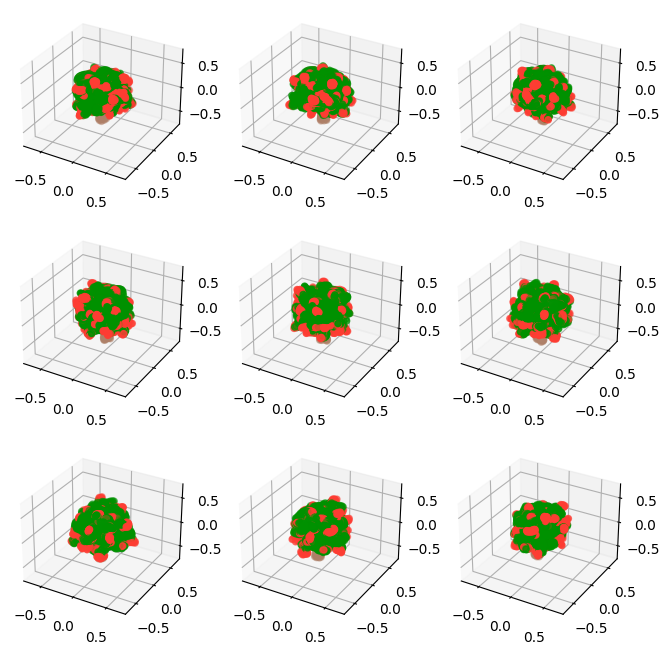

In [17]:
# Set a prompt to condition on.
prompt = 'apple tree'
# How many angles to show
previewGridSize = 3 # 3x3 grid of previews

# Generate a batch of samples.
# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x
    
# Generate the point cloud and plot it.
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=previewGridSize, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

Run the code below to look at the 3D Point Cloud Data ina browser!

In [18]:
# Render the point cloud in the browser
# Setup a plotly figure
fig_plotly = go.Figure(
   data=[
      go.Scatter3d(
         x=pc.coords[:, 0],y=pc.coords[:, 1],z=pc.coords[:, 2],
         mode='markers',
         marker=dict(
            size=5,
            color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels['R'], pc.channels['G'], pc.channels['B'])],
         )
      )
   ],
   layout=dict(
      scene=dict(
         bgcolor="rgb(30, 30, 30)",
         xaxis=dict(visible=False),
         yaxis=dict(visible=False),
         zaxis=dict(visible=False),
      )
   ),  
)

# Render the plotly figure
fig_plotly.show(renderer="browser")

___

#### Export Raw Point Clouds (Optional)
This code outputs the raw point cloud data, unmeshed, into the `raw_points` folder as .ply files.

In [19]:
# Write the mesh to a PLY file to import into some other program.
newP = prompt.replace(" ", "_") + "_" + str(random.randint(1, 1000000))
rawName = 'raw_points/'+newP+".raw.ply"

with open(rawName, 'wb') as f:
    pc.write_ply(f)
    
print("Generated point cloud saved to: "+rawName)

Generated point cloud saved to: raw_points/apple_tree_876875.raw.ply


___

####  Output Meshed .ply files (needed for next step)
This next code should mesh-ify the point cloud data into triangles for rendering.  This gets exported to the intermediates folder, but these are still.ply files.

In [20]:
# Produce a mesh (with vertex colors) from the point cloud. and write it to a PLY file.
mesh = marching_cubes_mesh(
    pc=pc,
    model=sdf_model,
    batch_size=4096,
    grid_size=64, # increase to 128 for resolution used in evals - 32 is faster
    progress=True,
)

newP = prompt.replace(" ", "_") + "_" + str(random.randint(1, 1000000))
fileName = 'intermediates/'+newP+".ply"

# Write the mesh to a PLY file to import into some other program.
with open(fileName, 'wb') as f:
    mesh.write_ply(f)
    
print("Generated mesh saved to: "+fileName)

  0%|          | 0/64 [00:00<?, ?it/s]

Generated mesh saved to: intermediates/apple_tree_376497.ply


___

Run the code below to use Blender to convert the meshed .ply into a .gltf.

In [21]:
# Convert the .ply mesh file to embedded .gltf file using Blender
!"$blender_path" -b -P 2gltf2.py -- "$fileName"
outputName = fileName.replace(".ply",".gltf").replace("intermediates/","outputs/")
print("\n============================================\n\n   .gltf file exported successfully! :)")
print("\n\n at the path: " + outputName)
print("\n\n============================================")

Blender 3.0.0 (hash f1cca3055776 built 2021-12-03 00:44:02)
Read prefs: C:\Users\Rayce\AppData\Roaming\Blender Foundation\Blender\3.0\config\userpref.blend
Converting: 'intermediates/apple_tree_376497.ply'

Successfully imported 'intermediates/apple_tree_376497.ply' in 1.057 sec
Writing: 'c:\Users\Rayce\point_e\point-e/outputs/apple_tree_376497.gltf'
'C:\Program Files\Blender Foundation\Blender 3.0\3.0\python\lib\site-packages\extern_draco.dll' exists, draco mesh compression is available
17:16:25 | INFO: Starting glTF 2.0 export
17:16:25 | INFO: Extracting primitive: apple_tree_376497
17:16:26 | INFO: Primitives created: 1
17:16:26 | INFO: Finished glTF 2.0 export in 0.18000006675720215 s


Blender quit


   .gltf file exported successfully! :)


 at the path: outputs/apple_tree_376497.gltf




Great!  You should now have a .ply or a .gltf model!

You can preview them with the 3D viewer in windows, or at [3DViewer.net](https://3DViewer.net) on a mac.

# BDE ♥
(Best Day Ever!!!)